# Cell 1: Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import warnings
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Eager execution: {tf.executing_eagerly()}")

TensorFlow version: 2.17.0
Eager execution: True


# Cell 2: Hàm tải dữ liệu Amazon

In [3]:
def load_amazon_data(file_path='amazon_cleaned.csv'):
    if not os.path.exists(file_path):
        print(f"Lỗi: Không tìm thấy tệp '{file_path}' trong thư mục '{os.getcwd()}'")
        return None
    try:
        df = pd.read_csv(file_path)
        print(f"Tải dữ liệu thành công từ '{file_path}'")
        return df
    except Exception as e:
        print(f"Lỗi khi tải dữ liệu: {e}")
        return None

file_path = "amazon_cleaned.csv"
df = load_amazon_data(file_path)
if df is not None:
    print(f"Kích thước dữ liệu: {df.shape}")
    print("\nThông tin cơ bản về dữ liệu:")
    df.info()

    # Hiển thị một số mẫu dữ liệu
    print("\nMẫu dữ liệu:")
    print(df.head())

Tải dữ liệu thành công từ 'amazon_cleaned.csv'
Kích thước dữ liệu: (79152, 19)

Thông tin cơ bản về dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79152 entries, 0 to 79151
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   product_id                79152 non-null  object 
 1   product_name              79152 non-null  object 
 2   category                  79152 non-null  object 
 3   review_id                 79152 non-null  object 
 4   rating                    79152 non-null  float64
 5   rating_count              79152 non-null  float64
 6   review_count              79152 non-null  int64  
 7   discounted_price          79152 non-null  float64
 8   actual_price              79152 non-null  float64
 9   discount_percentage       79152 non-null  float64
 10  purchase_count_estimated  79152 non-null  float64
 11  user_id                   79152 non-null  object 
 12  user_id

# Cell 3: Phân tích phân phối rating

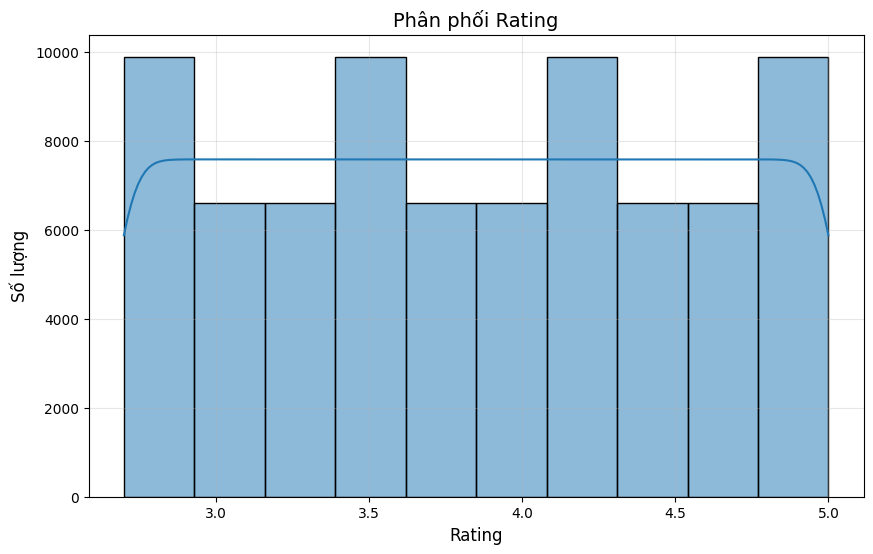

Thống kê cơ bản về rating:
count    79152.000000
mean         3.850000
std          0.692223
min          2.700000
25%          3.275000
50%          3.850000
75%          4.425000
max          5.000000
Name: rating, dtype: float64


In [4]:
if 'rating' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df['rating'], bins=10, kde=True)
    plt.title('Phân phối Rating', fontsize=14)
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('Số lượng', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

    # Thống kê cơ bản về rating
    print("Thống kê cơ bản về rating:")
    print(df['rating'].describe())

# Cell 4: Hàm tiền xử lý dữ liệu

In [5]:
def preprocess_data(df):
    print("Bắt đầu tiền xử lý dữ liệu...")
    processed_df = df.copy()
    if 'category' in processed_df.columns:
        processed_df = processed_df[['product_id', 'user_id', 'rating', 'product_name', 'category']]
    else:
        processed_df = processed_df[['product_id', 'user_id', 'rating', 'product_name']]
        print("Cảnh báo: Không tìm thấy cột 'category'")
    processed_df = processed_df.dropna(subset=['user_id', 'product_id', 'rating'])
   
    processed_df['rating'] = pd.to_numeric(processed_df['rating'], errors='coerce')
    processed_df = processed_df.dropna(subset=['rating'])  # Loại bỏ những dòng với rating không hợp lệ
    processed_df['rating'] = processed_df['rating'].clip(1, 5)

    # Chuẩn hóa rating để cải thiện sự ổn định trong huấn luyện
    scaler = MinMaxScaler(feature_range=(0, 1))
    processed_df['scaled_rating'] = scaler.fit_transform(processed_df[['rating']])

    # Mã hóa user_id và product_id thành chỉ số số nguyên
    user_encoder = LabelEncoder()
    product_encoder = LabelEncoder()

    processed_df['user_idx'] = user_encoder.fit_transform(processed_df['user_id'])
    processed_df['product_idx'] = product_encoder.fit_transform(processed_df['product_id'])

    # Tạo từ điển ánh xạ ngược để hiển thị kết quả
    idx_to_product = {idx: product for idx, product in zip(processed_df['product_idx'], processed_df['product_id'])}
    product_to_name = {pid: name for pid, name in zip(processed_df['product_id'], processed_df['product_name'])}

    # Thống kê
    num_users = processed_df['user_idx'].nunique()
    num_products = processed_df['product_idx'].nunique()
    print(f"Số lượng người dùng: {num_users}")
    print(f"Số lượng sản phẩm: {num_products}")
    print(f"Số lượng đánh giá: {len(processed_df)}")

    return processed_df, user_encoder, product_encoder, idx_to_product, product_to_name, scaler

df, user_encoder, product_encoder, idx_to_product, product_to_name, rating_scaler = preprocess_data(df)

Bắt đầu tiền xử lý dữ liệu...
Số lượng người dùng: 5000
Số lượng sản phẩm: 79152
Số lượng đánh giá: 79152


# Cell 5: Tạo mapping từ product_idx sang category

In [6]:
def create_category_mapping(df):
    """
    Tạo mapping từ product_idx sang category

    Args:
        df: DataFrame có chứa cột product_idx và category

    Returns:
        Dict: mapping từ product_idx sang category hoặc None nếu không có cột category
    """
    if 'category' not in df.columns:
        print("Không tìm thấy cột 'category' trong DataFrame")
        return None

    # Lấy danh mục cho từng product_idx
    category_mapping = {}
    product_categories = df[['product_idx', 'category']].drop_duplicates()

    for _, row in product_categories.iterrows():
        category_mapping[row['product_idx']] = row['category']

    print(f"Đã tạo category mapping cho {len(category_mapping)} sản phẩm")
    return category_mapping

# Tạo category mapping
category_mapping = create_category_mapping(df)

# Kiểm tra một số category
if category_mapping:
    print("\nMột số ví dụ về category:")
    for idx, category in list(category_mapping.items())[:5]:
        product_id = idx_to_product[idx]
        product_name = product_to_name[product_id]
        print(f"ID: {idx}, Sản phẩm: {product_name[:50]}..., Danh mục: {category}")

Đã tạo category mapping cho 79152 sản phẩm

Một số ví dụ về category:
ID: 63353, Sản phẩm: ReplacementScrews Stand Screws Compatible with Son..., Danh mục: Electronics
ID: 77488, Sản phẩm: Wireless Earbuds Bluetooth 5.3 Headphones 48hrs Sp..., Danh mục: Electronics
ID: 55680, Sản phẩm: Cyber Acoustics CA-3602FFP 2.1 Speaker Sound Syste..., Danh mục: Electronics
ID: 75373, Sản phẩm: Mothers Of Mayhem Presents: Swan Dongs..., Danh mục: Books
ID: 20076, Sản phẩm: ECS USB Foot Switch for Sony Digital Voice Editor;..., Danh mục: Electronics


# Cell 7: Phân tích theo danh mục (nếu có)

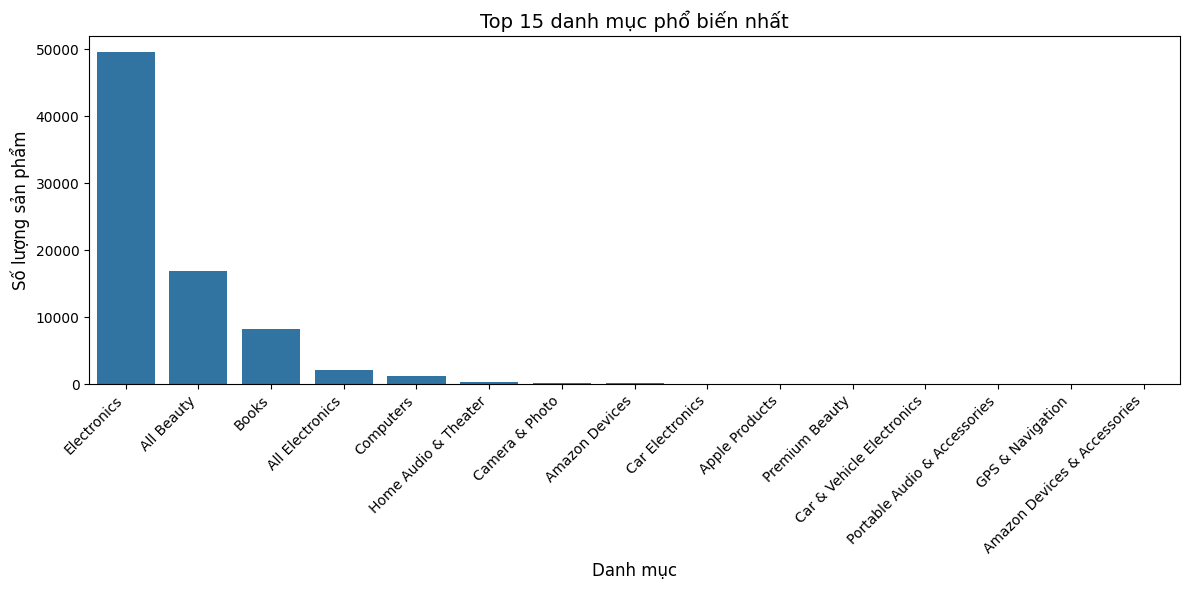

Tổng số danh mục: 16

Top 10 danh mục phổ biến nhất:
category
Electronics             49531
All Beauty              16860
Books                    8291
All Electronics          2161
Computers                1280
Home Audio & Theater      341
Camera & Photo            206
Amazon Devices            154
Car Electronics            85
Apple Products             69
Name: count, dtype: int64


In [7]:
if 'category' in df.columns:
    category_counts = df['category'].value_counts()

    plt.figure(figsize=(12, 6))
    top_categories = category_counts.head(15)
    sns.barplot(x=top_categories.index, y=top_categories.values)
    plt.title('Top 15 danh mục phổ biến nhất', fontsize=14)
    plt.xlabel('Danh mục', fontsize=12)
    plt.ylabel('Số lượng sản phẩm', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(f"Tổng số danh mục: {len(category_counts)}")
    print("\nTop 10 danh mục phổ biến nhất:")
    print(category_counts.head(10))

# Cell 8: Xây dựng mô hình Deep Matrix Factorization

In [8]:
# Cell 8: Xây dựng mô hình Deep Matrix Factorization

def build_deep_mf_model(num_users, num_products, embedding_size=32):  # Thay đổi từ 16 thành 32

    # Input layers
    user_input = Input(shape=(1,), name='user_input', dtype='int32')
    product_input = Input(shape=(1,), name='product_input', dtype='int32')

    user_embedding = Embedding(
        input_dim=num_users,
        output_dim=embedding_size,  # Sử dụng embedding_size mới
        embeddings_initializer='glorot_normal',  # Xavier initialization
        embeddings_regularizer=l2(0.01),  # Tăng regularization để tránh overfitting
        name='user_embedding'
    )(user_input)

    product_embedding = Embedding(
        input_dim=num_products,
        output_dim=embedding_size,  # Sử dụng embedding_size mới
        embeddings_initializer='glorot_normal',  # Xavier initialization
        embeddings_regularizer=l2(0.01),  # Tăng regularization
        name='product_embedding'
    )(product_input)

    # Flatten embeddings
    user_vector = Flatten()(user_embedding)
    product_vector = Flatten()(product_embedding)

    # Concatenate embeddings
    concat = Concatenate()([user_vector, product_vector])

    # Deep layers với batch normalization để ổn định quá trình học
    # Điều chỉnh kích thước các layer dense để phù hợp với embedding lớn hơn
    dense1 = Dense(256, kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(concat)  # Tăng từ 128 lên 256
    bn1 = BatchNormalization()(dense1)
    activation1 = tf.keras.layers.LeakyReLU(0.0001)(bn1)  # LeakyReLU để tránh dying neurons
    dropout1 = Dropout(0.2)(activation1)

    dense2 = Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(dropout1)  # Tăng từ 64 lên 128
    bn2 = BatchNormalization()(dense2)
    activation2 = tf.keras.layers.LeakyReLU(0.0001)(bn2)
    dropout2 = Dropout(0.2)(activation2)

    dense3 = Dense(64, kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(dropout2)  # Tăng từ 32 lên 64
    bn3 = BatchNormalization()(dense3)
    activation3 = tf.keras.layers.LeakyReLU(0.0001)(bn3)

    output = Dense(1, activation='sigmoid')(activation3)
    model = Model(inputs=[user_input, product_input], outputs=output)
    optimizer = Adam(learning_rate=0.00001, clipnorm=1.0)

    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

# Khởi tạo mô hình với embedding_size mới
num_users = df['user_idx'].nunique()
num_products = df['product_idx'].nunique()
model = build_deep_mf_model(num_users, num_products, embedding_size=32)  # Thay đổi embedding_size
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 32)     │    160,000 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_embedding   │ (None, 1, 32)     │  2,532,864 │ product_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ product_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     16,640 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ leaky_re_lu_2[0]… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 2,752,513 (10.50 MB)

 Trainable params: 2,751,617 (10.50 MB)

 Non-trainable params: 896 (3.50 KB)

# Cell 9: Tạo và huấn luyện mô hình

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Tập huấn luyện: {len(train_df)} mẫu")
print(f"Tập kiểm tra: {len(test_df)} mẫu")

# Callbacks để cải thiện quá trình huấn luyện và tránh NaN
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Huấn luyện mô hình
history = model.fit(
    [train_df['user_idx'], train_df['product_idx']],
    train_df['scaled_rating'],  # Sử dụng giá trị đã scale
    epochs=30,
    batch_size=64,  # Tăng batch size từ 32 lên 64 để tối ưu hóa cho embedding lớn hơn
    validation_data=(
        [test_df['user_idx'], test_df['product_idx']],
        test_df['scaled_rating']  # Sử dụng giá trị đã scale
    ),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

Tập huấn luyện: 63321 mẫu
Tập kiểm tra: 15831 mẫu
Epoch 1/30
990/990 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.9670 - mae: 0.2898
Epoch 1: val_loss improved from inf to 1.55312, saving model to best_model.keras
990/990 ━━━━━━━━━━━━━━━━━━━━ 60s 57ms/step - loss: 1.9668 - mae: 0.2898 - val_loss: 1.5531 - val_mae: 0.2732 - learning_rate: 1.0000e-05
Epoch 2/30
990/990 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.5164 - mae: 0.2793
Epoch 2: val_loss improved from 1.55312 to 1.39504, saving model to best_model.keras
990/990 ━━━━━━━━━━━━━━━━━━━━ 60s 61ms/step - loss: 1.5163 - mae: 0.2793 - val_loss: 1.3950 - val_mae: 0.2696 - learning_rate: 1.0000e-05
Epoch 3/30
990/990 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.3695 - mae: 0.2708
Epoch 3: val_loss improved from 1.39504 to 1.28113, saving model to best_model.keras
990/990 ━━━━━━━━━━━━━━━━━━━━ 59s 59ms/step - loss: 1.3695 - mae: 0.2708 - val_loss: 1.2811 - val_mae: 0.2678 - learning_rate: 1.0000e-05
Epoch 4/30
990/990 ━━━━━━━━━━━━━━━━━━━━ 0s

# Cell 10: Đánh giá mô hình

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test MAE: 0.2686
Test RMSE: 0.3151


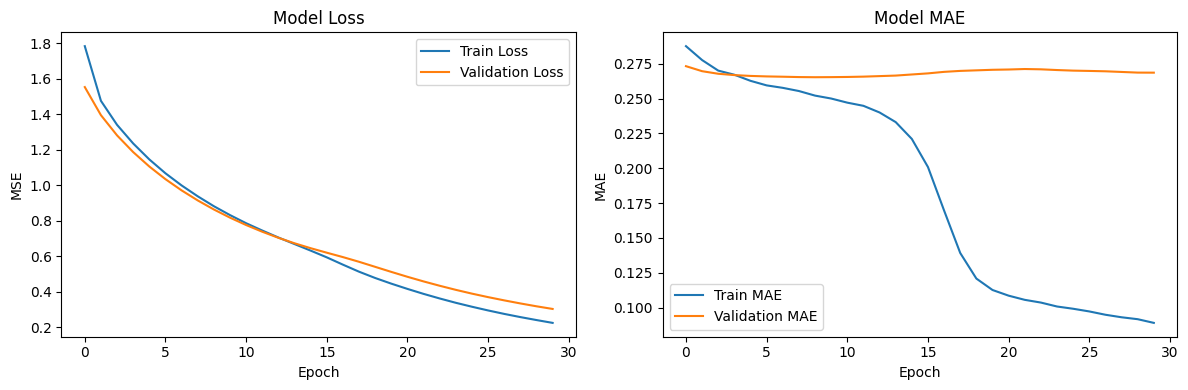

In [10]:
def evaluate_model(model, test_df):
    predictions = model.predict([test_df['user_idx'], test_df['product_idx']], batch_size=256)
    mae = mean_absolute_error(test_df['scaled_rating'], predictions)
    rmse = np.sqrt(mean_squared_error(test_df['scaled_rating'], predictions))
    print(f"Test MAE: {mae:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    return mae, rmse
# Đánh giá mô hình
evaluate_model(model, test_df)

# Vẽ biểu đồ
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Cell 11: Hàm gợi ý sản phẩm dựa trên tương đồng

In [11]:
def recommend_products_similarity(user_idx, df, idx_to_product, product_to_name,
                                 user_embeddings, product_embeddings,
                                 category_mapping=None, recent_views=None,
                                 top_n=5, category_weight=0.6):
    user_embedding = user_embeddings[user_idx]
    rated_products = set(df[df['user_idx'] == user_idx]['product_idx'])
    preferred_category = None
    if category_mapping:
        user_ratings = df[df['user_idx'] == user_idx]
        user_categories = []
        for _, row in user_ratings.iterrows():
            product_idx = row['product_idx']
            if product_idx in category_mapping:
                user_categories.append(category_mapping[product_idx])
        if user_categories:
            from collections import Counter
            preferred_category = Counter(user_categories).most_common(1)[0][0]
    recent_category = None
    if recent_views and category_mapping:
        for product_idx in recent_views:
            if product_idx in category_mapping:
                recent_category = category_mapping[product_idx]
                break
    num_products = len(product_embeddings)
    unrated_products = [i for i in range(num_products) if i not in rated_products]

    if not unrated_products:
        print(f"Người dùng {user_idx} đã đánh giá tất cả sản phẩm")
        return []
    similarities = []

    for product_idx in unrated_products:
        product_embedding = product_embeddings[product_idx]
        epsilon = 1e-8
        dot_product = np.dot(user_embedding, product_embedding)
        norm_user = max(np.linalg.norm(user_embedding), epsilon)
        norm_product = max(np.linalg.norm(product_embedding), epsilon)

        cosine_sim = dot_product / (norm_user * norm_product)
        category_bonus = 0
        if category_mapping and product_idx in category_mapping:
            product_category = category_mapping[product_idx]
            if recent_category and product_category == recent_category:
                category_bonus = category_weight
            elif preferred_category and product_category == preferred_category:
                category_bonus = category_weight * 0.8
        final_score = (1 - category_weight) * cosine_sim + category_bonus

        similarities.append((product_idx, final_score, cosine_sim))
    similarities.sort(key=lambda x: x[1], reverse=True)
    top_products = similarities[:top_n]
    recommendations = []
    for product_idx, final_score, cosine_sim in top_products:
        product_id = idx_to_product[product_idx]
        product_name = product_to_name.get(product_id, "Unknown")
        product_category = None
        if category_mapping and product_idx in category_mapping:
            product_category = category_mapping[product_idx]
        predicted_rating = 1 + (cosine_sim + 1) * 2

        recommendations.append({
            'product_id': product_id,
            'product_name': product_name,
            'similarity': cosine_sim,
            'category': product_category,
            'final_score': final_score,
            'predicted_rating': predicted_rating
        })

    return recommendations

# Cell 12: Thử nghiệm hệ thống gợi ý

In [12]:
# Lấy embeddings từ model
user_embedding_layer = model.get_layer('user_embedding')
user_embeddings = user_embedding_layer.get_weights()[0]

product_embedding_layer = model.get_layer('product_embedding')
product_embeddings = product_embedding_layer.get_weights()[0]

print(f"Kích thước embedding người dùng: {user_embeddings.shape}")
print(f"Kích thước embedding sản phẩm: {product_embeddings.shape}")

# Thử nghiệm gợi ý cho một số người dùng
print("\nĐề xuất sản phẩm cho một số người dùng với cải tiến về danh mục:")

# Chọn một số người dùng để thử nghiệm
sample_users = np.random.choice(df['user_idx'].unique(), min(3, len(df['user_idx'].unique())), replace=False)

for user_idx in sample_users:
    user_id = user_encoder.inverse_transform([user_idx])[0]
    print(f"\nĐề xuất cho người dùng {user_id} (index: {user_idx}):")

    # Lấy thông tin về các sản phẩm mà người dùng đã đánh giá
    user_ratings = df[df['user_idx'] == user_idx]
    print(f"Người dùng đã đánh giá {len(user_ratings)} sản phẩm")

    if len(user_ratings) > 0:
        print("Một số sản phẩm đã đánh giá:")
        for _, row in user_ratings.head(3).iterrows():
            product_category = "N/A"
            if category_mapping and row['product_idx'] in category_mapping:
                product_category = category_mapping[row['product_idx']]
            print(f"  - {row['product_name'][:40]}... | Danh mục: {product_category} | Rating: {row['rating']}")

    # Giả lập sản phẩm đã xem gần đây (lấy một sản phẩm ngẫu nhiên từ lịch sử người dùng)
    recent_view = None
    if len(user_ratings) > 0:
        recent_product = user_ratings.sample(1).iloc[0]
        recent_view = [recent_product['product_idx']]

        print(f"\nSản phẩm đã xem gần đây: {recent_product['product_name'][:40]}...")
        if category_mapping and recent_product['product_idx'] in category_mapping:
            recent_category = category_mapping[recent_product['product_idx']]
            print(f"Danh mục gần đây: {recent_category}")

    # Đề xuất sản phẩm mới với cải tiến về danh mục
    recommendations = recommend_products_similarity(
        user_idx, df, idx_to_product, product_to_name,
        user_embeddings, product_embeddings,
        category_mapping=category_mapping,
        recent_views=recent_view,
        top_n=5,
        category_weight=0.6
    )

    print("\nSản phẩm được đề xuất:")
    for i, rec in enumerate(recommendations, 1):
        name = rec['product_name'][:40] + '...' if len(rec['product_name']) > 40 else rec['product_name']
        category = rec['category'] if rec['category'] else "Không xác định"
        print(f"{i}. {name}")
        print(f"   Danh mục: {category}")
        print(f"   Độ tương tự: {rec['similarity']:.4f}")
        print(f"   Điểm tổng hợp: {rec['final_score']:.4f}")
        print(f"   Dự đoán đánh giá: {rec['predicted_rating']:.2f}/5.0")


Kích thước embedding người dùng: (5000, 32)
Kích thước embedding sản phẩm: (79152, 32)

Đề xuất sản phẩm cho một số người dùng với cải tiến về danh mục:

Đề xuất cho người dùng AFYJSCEJ4HBUL3T5VMPO65YA2EYQ (index: 2471):
Người dùng đã đánh giá 12 sản phẩm
Một số sản phẩm đã đánh giá:
  - Google Home Mini Power Cord; Replacement... | Danh mục: Electronics | Rating: 4.7
  - Hand Cream Set - Alinice 10 Pack Plant F... | Danh mục: All Beauty | Rating: 4.6
  - Sony Bloggie 3D Camera (Black) (Disconti... | Danh mục: Electronics | Rating: 3.1

Sản phẩm đã xem gần đây: YYST 2 Inch Padded Replacement Shoulder ...
Danh mục gần đây: Electronics

Sản phẩm được đề xuất:
1. Halter Standing Desk Converter for Home ...
   Danh mục: Electronics
   Độ tương tự: 0.4691
   Điểm tổng hợp: 0.7876
   Dự đoán đánh giá: 3.94/5.0
2. Voistek Telephone Headset with Noise Can...
   Danh mục: Electronics
   Độ tương tự: 0.4432
   Điểm tổng hợp: 0.7773
   Dự đoán đánh giá: 3.89/5.0
3. XBOSS X8 Wireless IR Remote Con

# Cell 13: Kiểm tra hiệu quả của trọng số danh mục

Trọng số danh mục 0.0: 36.00% gợi ý cùng danh mục
Trọng số danh mục 0.2: 94.00% gợi ý cùng danh mục
Trọng số danh mục 0.4: 100.00% gợi ý cùng danh mục
Trọng số danh mục 0.6: 100.00% gợi ý cùng danh mục
Trọng số danh mục 0.8: 100.00% gợi ý cùng danh mục


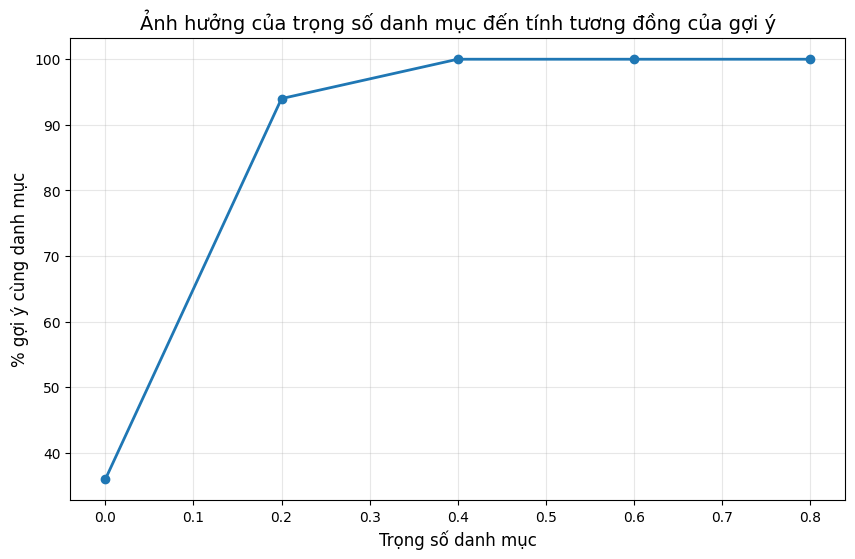

In [13]:
def test_category_effectiveness(df, model, category_mapping, top_n=5):
    # Lấy embeddings
    user_embedding_layer = model.get_layer('user_embedding')
    user_embeddings = user_embedding_layer.get_weights()[0]

    product_embedding_layer = model.get_layer('product_embedding')
    product_embeddings = product_embedding_layer.get_weights()[0]

    # Lấy mẫu ngẫu nhiên 50 người dùng
    num_users_to_test = min(50, len(df['user_idx'].unique()))
    sample_users = np.random.choice(df['user_idx'].unique(), num_users_to_test, replace=False)

    total_recs = 0
    same_category_recs = 0

    for user_idx in sample_users:
        # Lấy các sản phẩm đã đánh giá của người dùng
        user_ratings = df[df['user_idx'] == user_idx]

        if len(user_ratings) == 0:
            continue

        # Chọn ngẫu nhiên một sản phẩm làm "recent view"
        recent_product = user_ratings.sample(1).iloc[0]
        recent_view = [recent_product['product_idx']]

        # Lấy danh mục của sản phẩm gần đây
        if category_mapping and recent_product['product_idx'] in category_mapping:
            recent_category = category_mapping[recent_product['product_idx']]
        else:
            continue  # Bỏ qua nếu không có thông tin danh mục

        # Gợi ý sản phẩm
        recommendations = recommend_products_similarity(
            user_idx, df, idx_to_product, product_to_name,
            user_embeddings, product_embeddings,
            category_mapping=category_mapping,
            recent_views=recent_view,
            top_n=top_n,
            category_weight=0.6  # Dùng trọng số cao cho danh mục
        )

        # Đếm số sản phẩm cùng danh mục
        for rec in recommendations:
            total_recs += 1
            if rec['category'] == recent_category:
                same_category_recs += 1

    # Tính tỉ lệ
    if total_recs > 0:
        same_category_percentage = (same_category_recs / total_recs) * 100
    else:
        same_category_percentage = 0

    return same_category_percentage

# Kiểm tra tỉ lệ gợi ý cùng danh mục với các trọng số khác nhau
if category_mapping:
    category_weights = [0.0, 0.2, 0.4, 0.6, 0.8]
    results = []

    # Xác định hàm test với trọng số cụ thể
    def test_with_specific_weight(df, model, category_mapping, category_weight, top_n=5):
        """Kiểm tra hiệu quả với trọng số cụ thể"""
        # Lấy embeddings
        user_embedding_layer = model.get_layer('user_embedding')
        user_embeddings = user_embedding_layer.get_weights()[0]
        
        product_embedding_layer = model.get_layer('product_embedding')
        product_embeddings = product_embedding_layer.get_weights()[0]
        
        # Lấy mẫu ngẫu nhiên người dùng
        num_users_to_test = min(20, len(df['user_idx'].unique()))
        sample_users = np.random.choice(df['user_idx'].unique(), num_users_to_test, replace=False)
        
        total_recs = 0
        same_category_recs = 0
        
        for user_idx in sample_users:
            # Lấy các sản phẩm đã đánh giá của người dùng
            user_ratings = df[df['user_idx'] == user_idx]
            
            if len(user_ratings) == 0:
                continue
                
            # Chọn ngẫu nhiên một sản phẩm làm "recent view"
            recent_product = user_ratings.sample(1).iloc[0]
            recent_view = [recent_product['product_idx']]
            
            # Lấy danh mục gần đây
            if category_mapping and recent_product['product_idx'] in category_mapping:
                recent_category = category_mapping[recent_product['product_idx']]
            else:
                continue
            
            # Lấy các sản phẩm đã được đánh giá bởi người dùng
            rated_products = set(df[df['user_idx'] == user_idx]['product_idx'])
            # Các sản phẩm chưa đánh giá
            unrated_products = [i for i in range(len(product_embeddings)) if i not in rated_products]
            
            if not unrated_products:
                continue
                
            # Tính toán điểm tương tự kết hợp với bonus danh mục
            similarities = []
            for product_idx in unrated_products:
                product_embedding = product_embeddings[product_idx]
                user_embedding = user_embeddings[user_idx]
                
                # Tính độ tương tự cosine
                epsilon = 1e-8
                dot_product = np.dot(user_embedding, product_embedding)
                norm_user = max(np.linalg.norm(user_embedding), epsilon)
                norm_product = max(np.linalg.norm(product_embedding), epsilon)
                cosine_sim = dot_product / (norm_user * norm_product)
                
                # Tính điểm danh mục
                category_bonus = 0
                if category_mapping and product_idx in category_mapping:
                    product_category = category_mapping[product_idx]
                    # Bonus cho danh mục gần đây
                    if product_category == recent_category:
                        category_bonus = category_weight
                
                # Tính điểm tổng hợp
                final_score = (1 - category_weight) * cosine_sim + category_bonus
                
                similarities.append((product_idx, final_score))
            
            # Sắp xếp theo điểm cao nhất
            similarities.sort(key=lambda x: x[1], reverse=True)
            
            # Lấy top-n sản phẩm
            top_products = similarities[:top_n]
            
            # Đếm số sản phẩm cùng danh mục
            for product_idx, _ in top_products:
                total_recs += 1
                if category_mapping and product_idx in category_mapping:
                    if category_mapping[product_idx] == recent_category:
                        same_category_recs += 1
        
        # Tính tỉ lệ phần trăm
        if total_recs > 0:
            same_category_percentage = (same_category_recs / total_recs) * 100
        else:
            same_category_percentage = 0
            
        return same_category_percentage
    
    # Kiểm tra với các trọng số khác nhau
    for weight in category_weights:
        percent = test_with_specific_weight(df, model, category_mapping, weight)
        results.append((weight, percent))
        print(f"Trọng số danh mục {weight:.1f}: {percent:.2f}% gợi ý cùng danh mục")
    
    # Trực quan hóa kết quả
    plt.figure(figsize=(10, 6))
    plt.plot([r[0] for r in results], [r[1] for r in results], 'o-', linewidth=2)
    plt.title('Ảnh hưởng của trọng số danh mục đến tính tương đồng của gợi ý', fontsize=14)
    plt.xlabel('Trọng số danh mục', fontsize=12)
    plt.ylabel('% gợi ý cùng danh mục', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

# Cell 14: Phân cụm sản phẩm với K-Means

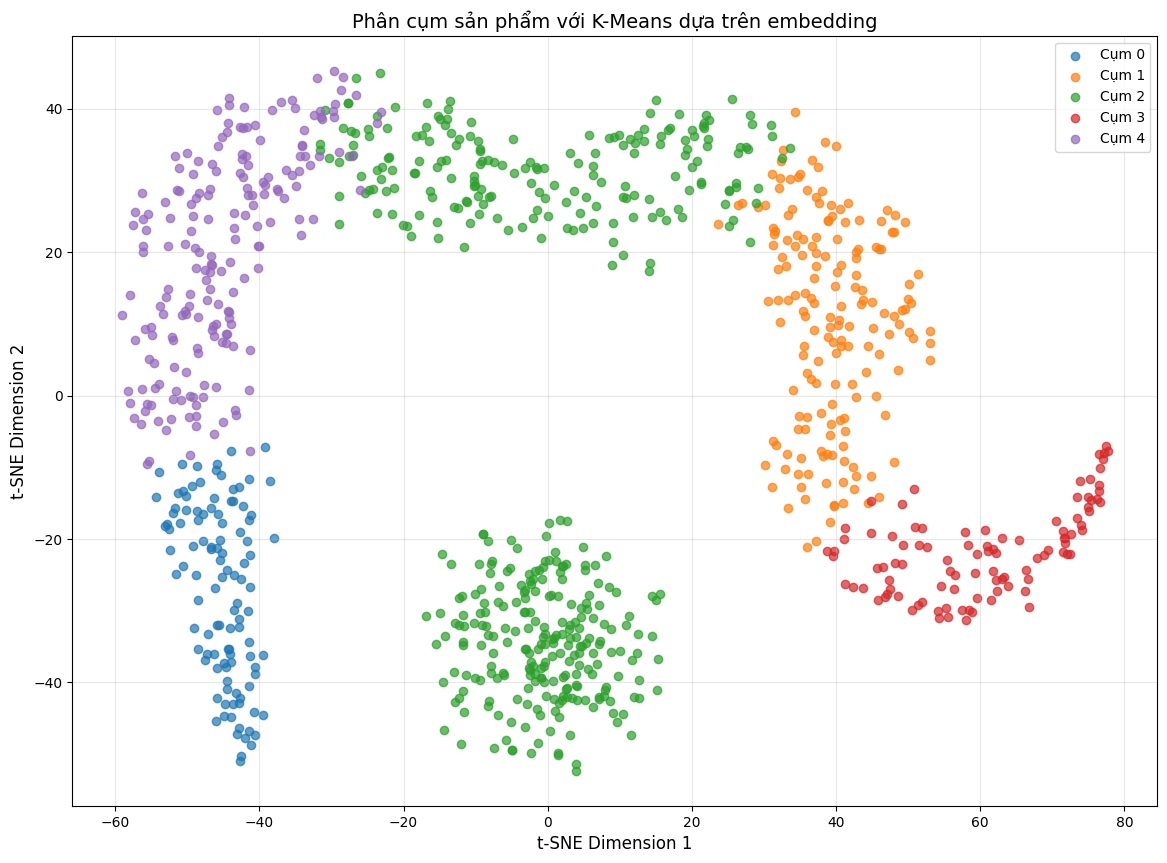

In [15]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Đặt số lượng cụm
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
product_clusters = kmeans.fit_predict(product_embeddings)

# Giảm chiều dữ liệu để trực quan hóa
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
product_embeddings_2d = tsne.fit_transform(product_embeddings)

# Lấy mẫu để trực quan hóa (tối đa 1000 sản phẩm)
n_products = min(1000, len(product_embeddings))
sample_indices = np.random.choice(len(product_embeddings), n_products, replace=False)

plt.figure(figsize=(14, 10))

for cluster_id in range(n_clusters):
    cluster_indices = np.where(product_clusters == cluster_id)[0]
    cluster_samples = np.intersect1d(cluster_indices, sample_indices)
    
    plt.scatter(
        product_embeddings_2d[cluster_samples, 0],
        product_embeddings_2d[cluster_samples, 1],
        label=f'Cụm {cluster_id}',
        alpha=0.7
    )

plt.title('Phân cụm sản phẩm với K-Means dựa trên embedding', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
print("\nPhân tích các cụm sản phẩm:")
for cluster_id in range(n_clusters):
    # Lấy chỉ mục của sản phẩm thuộc cụm này
    cluster_indices = np.where(product_clusters == cluster_id)[0]
    
    print(f"\nCụm {cluster_id} (Số lượng sản phẩm: {len(cluster_indices)}):")
    
    # Tính rating trung bình của cụm
    cluster_ratings = []
    for idx in cluster_indices:
        product_ratings = df[df['product_idx'] == idx]['rating']
        if not product_ratings.empty:
            cluster_ratings.extend(product_ratings.tolist())
    
    avg_rating = np.mean(cluster_ratings) if cluster_ratings else 0
    print(f"Rating trung bình: {avg_rating:.2f}")
    
    # Phân tích danh mục trong cụm
    if category_mapping:
        cluster_categories = {}
        for idx in cluster_indices:
            if idx in category_mapping:
                category = category_mapping[idx]
                if category in cluster_categories:
                    cluster_categories[category] += 1
                else:
                    cluster_categories[category] = 1
        
        # Hiển thị top 5 danh mục phổ biến nhất trong cụm
        top_categories = sorted(cluster_categories.items(), key=lambda x: x[1], reverse=True)[:5]
        print("Top danh mục phổ biến:")
        for category, count in top_categories:
            print(f"  - {category}: {count} sản phẩm ({count/len(cluster_indices)*100:.1f}%)")
    
    # Hiển thị 5 sản phẩm đầu tiên trong cụm
    print("Mẫu sản phẩm trong cụm:")
    for idx in cluster_indices[:5]:
        if idx in idx_to_product:
            product_id = idx_to_product[idx]
            product_name = product_to_name.get(product_id, "Unknown")
            print(f"  - {product_name[:50]}...")


Phân tích các cụm sản phẩm:

Cụm 0 (Số lượng sản phẩm: 8457):
Rating trung bình: 2.89
Top danh mục phổ biến:
  - Electronics: 4453 sản phẩm (52.7%)
  - All Beauty: 3127 sản phẩm (37.0%)
  - Books: 322 sản phẩm (3.8%)
  - All Electronics: 295 sản phẩm (3.5%)
  - Computers: 144 sản phẩm (1.7%)
Mẫu sản phẩm trong cụm:
  - Fishing Fame! How to Catch a World Record Fish...
  - Always Love...
  - Ocean Acidification: A National Strategy to Meet t...
  - How to Carve a Cardinal: A Step-by-Step Guide for ...
  - Streetfinder: Jackson (Rand McNally Streetfinder)...

Cụm 1 (Số lượng sản phẩm: 14673):
Rating trung bình: 4.42
Top danh mục phổ biến:
  - Electronics: 9832 sản phẩm (67.0%)
  - Books: 2311 sản phẩm (15.8%)
  - All Beauty: 1906 sản phẩm (13.0%)
  - All Electronics: 266 sản phẩm (1.8%)
  - Computers: 174 sản phẩm (1.2%)
Mẫu sản phẩm trong cụm:
  - Rachel's Favourite Food at Home...
  - A Classic Case of Dr. Seuss...
  - Sleeper's Castle...
  - Flora's Magic House...
  - Princess in Wai

# Cell 15: Lưu embedding ra tệp .npy

In [17]:
# Lấy các embedding của người dùng và sản phẩm
user_embedding_layer = model.get_layer('user_embedding')
user_embeddings = user_embedding_layer.get_weights()[0]

product_embedding_layer = model.get_layer('product_embedding')
product_embeddings = product_embedding_layer.get_weights()[0]

print(f"Kích thước embedding người dùng: {user_embeddings.shape}")
print(f"Kích thước embedding sản phẩm: {product_embeddings.shape}")

# Lưu embedding vào tệp .npy
np.save('user_embeddings.npy', user_embeddings)
np.save('product_embeddings.npy', product_embeddings)

Kích thước embedding người dùng: (5000, 32)
Kích thước embedding sản phẩm: (79152, 32)


# Cell 16: Tạo từ điển ánh xạ sản phẩm với keywords/category

In [18]:
import ast

# Sau đó là code hiện tại của bạn
df_cleaned = pd.read_csv(r'amazon_cleaned.csv')
if 'Generated_Keywords' in df_cleaned.columns:
    keyword_column = 'Generated_Keywords'
else:
    keyword_column = None
    print("Không tìm thấy cột keywords, sẽ sử dụng danh mục sản phẩm thay thế")

# Tạo mapping sản phẩm với keywords/category
product_category_mapping = {}
if keyword_column:
    product_category_mapping = df_cleaned.groupby("product_id")[keyword_column].apply(
        lambda x: list(set([kw for item in x for kw in ast.literal_eval(item) if isinstance(kw, str)]))
    ).to_dict()
else:
    product_category_mapping = df_cleaned.groupby("product_id")["category"].apply(
        lambda x: list(set([item for item in x if isinstance(item, str)]))
    ).to_dict()

print("Sample product_category_mapping:")
for k, v in list(product_category_mapping.items())[:5]:
    print(k, v)

# Tính danh mục ưa thích của người dùng
user_preferred_category = df_cleaned.groupby("user_id")["category"].agg(
    lambda x: x.dropna().value_counts().index[0] if not x.dropna().empty else None
).to_dict()

# Tính điểm phổ biến (chuẩn hóa)
df_cleaned["rating_count"] = pd.to_numeric(df_cleaned["rating_count"], errors='coerce')
df_cleaned["rating"] = pd.to_numeric(df_cleaned["rating"], errors='coerce')
df_cleaned["popularity_score"] = df_cleaned["rating_count"] * df_cleaned["rating"]
max_popularity = df_cleaned["popularity_score"].max()
df_cleaned["popularity_score"] = df_cleaned["popularity_score"] / max_popularity  # Chuẩn hóa về [0, 1]
popularity_scores = df_cleaned.drop_duplicates("product_idx").set_index("product_idx")["popularity_score"].to_dict()

# Giả định rằng bạn đã có user_embeddings và product_embeddings từ trước
try:
    user_embeddings = np.load('user_embeddings.npy')
    product_embeddings = np.load('product_embeddings.npy')
    if user_embeddings is None or product_embeddings is None:
        raise ValueError("user_embeddings hoặc product_embeddings chưa được định nghĩa")
    print("Đã sử dụng embedding có sẵn:")
    print(f"User embeddings shape: {user_embeddings.shape}")
    print(f"Product embeddings shape: {product_embeddings.shape}")
except NameError:
    print("Lỗi: user_embeddings hoặc product_embeddings chưa được định nghĩa. Vui lòng cung cấp trước khi chạy.")
    user_embeddings = None
    product_embeddings = None

# Xây dựng KNN
if product_embeddings is not None:
    knn_items = NearestNeighbors(n_neighbors=min(50, len(product_embeddings)), metric="cosine")
    knn_items.fit(product_embeddings)
    print("Đã xây dựng KNN thành công với product_embeddings")
else:
    print("Không có product_embeddings để xây dựng KNN")
    knn_items = None

# Mapping product_idx -> product_id
product_id_mapping = df_cleaned.drop_duplicates("product_idx").set_index("product_idx")["product_id"].to_dict()

# Mapping product_idx -> Keywords
product_keywords = {p_idx: product_category_mapping.get(p_id, []) for p_idx, p_id in product_id_mapping.items()}

# Tính xu hướng danh mục phổ biến
category_trends = df_cleaned["category"].value_counts().index[0]
print(f"Danh mục xu hướng phổ biến nhất: {category_trends}")

Sample product_category_mapping:
000221718X ['home', 'books']
000472111X ['dolphins', 'books', 'gem']
000651216X ['committee', 'books']
000712838X ['give', 'muffin', 'books', 'moose']
000712855X ['andrew', 'looking', 'mccarthy']
Đã sử dụng embedding có sẵn:
User embeddings shape: (5000, 32)
Product embeddings shape: (79152, 32)
Đã xây dựng KNN thành công với product_embeddings
Danh mục xu hướng phổ biến nhất: Electronics


# Cell 17: Hàm tìm từ khóa tìm kiếm gần đây

In [19]:
def get_recent_search_keywords(df, user_id, top_n_keywords=3, time_window_hours=24, fallback_to_all=True):
    """
    Lấy từ khóa tìm kiếm gần đây của người dùng với tùy chọn fallback
    """
    import ast
    import pandas as pd
    from collections import Counter

    print(f"\n=== Tìm từ khóa cho người dùng {user_id} ===")

    # Kiểm tra DataFrame
    if df is None or len(df) == 0:
        print("Lỗi: DataFrame trống")
        return []

    print(f"DataFrame có {len(df)} dòng và các cột: {list(df.columns)}")

    # Kiểm tra user_id trong DataFrame
    if 'user_id' not in df.columns:
        print("Lỗi: Không tìm thấy cột user_id")
        return []

    # Kiểm tra Generated_Keywords trong DataFrame
    if 'Generated_Keywords' not in df.columns:
        print("Lỗi: Không tìm thấy cột Generated_Keywords")
        return []

    # Lọc theo user_id
    user_data = df[df['user_id'] == user_id]
    print(f"Tìm thấy {len(user_data)} dòng cho user_id={user_id}")

    if len(user_data) == 0:
        print("Không có dữ liệu cho user_id này")
        return []

    # Xử lý timestamp
    recent_data = user_data
    if 'Timestamp' in df.columns:
        try:
            # [Phần xử lý timestamp giữ nguyên]

            # Lọc theo thời gian
            if user_data['Timestamp'].notna().any():
                current_time = pd.Timestamp.now()
                cutoff_time = current_time - pd.Timedelta(hours=time_window_hours)
                print(f"Lọc từ {cutoff_time} đến {current_time}")

                recent_data = user_data[user_data['Timestamp'] >= cutoff_time]
                print(f"Số dòng sau khi lọc thời gian: {len(recent_data)}")

                # THAY ĐỔI Ở ĐÂY: Sử dụng tất cả dữ liệu nếu không có dữ liệu gần đây
                if len(recent_data) == 0 and fallback_to_all:
                    print("Không có dữ liệu gần đây, sử dụng tất cả dữ liệu của người dùng")
                    recent_data = user_data
            else:
                print("Không có timestamp hợp lệ, sử dụng tất cả dữ liệu người dùng")
        except Exception as e:
            print(f"Lỗi xử lý timestamp: {e}")

    if len(recent_data) == 0:
        print("Không còn dữ liệu sau khi lọc thời gian")
        return []

    # Xử lý từ khóa
    print(f"\nPhân tích từ khóa từ {len(recent_data)} dòng...")

    # Hiển thị mẫu dữ liệu Generated_Keywords
    keyword_samples = recent_data['Generated_Keywords'].head().tolist()
    print(f"Mẫu Generated_Keywords: {keyword_samples}")

    all_keywords = []
    processed_rows = 0
    error_rows = 0

    for idx, row in recent_data.iterrows():
        processed_rows += 1
        keywords_str = row.get('Generated_Keywords')

        if pd.isna(keywords_str):
            continue

        try:
            # Phân tích từ khóa
            if isinstance(keywords_str, str):
                # Nếu là chuỗi, cân phân tích
                if keywords_str.strip().startswith('[') and keywords_str.strip().endswith(']'):
                    # Trông giống chuỗi danh sách, phân tích nó
                    keywords = ast.literal_eval(keywords_str)
                    if isinstance(keywords, list):
                        print(f"Phân tích danh sách từ khóa: {keywords[:5]}..." if len(keywords) > 5 else keywords)
                        all_keywords.extend(keywords)
                    else:
                        print(f"Từ khóa không phải danh sách sau khi phân tích: {type(keywords)}")
                else:
                    # Coi như một từ khóa duy nhất
                    all_keywords.append(keywords_str)
            elif isinstance(keywords_str, list):
                # Nếu đã là danh sách, sử dụng trực tiếp
                all_keywords.extend(keywords_str)
            else:
                print(f"Loại từ khóa không mong đợi: {type(keywords_str)}")
        except Exception as e:
            error_rows += 1
            print(f"Lỗi khi phân tích từ khóa '{str(keywords_str)[:30]}...': {e}")

    print(f"Đã xử lý {processed_rows} dòng, có {error_rows} lỗi")
    print(f"Tổng số từ khóa đã trích xuất: {len(all_keywords)}")

    if not all_keywords:
        print("Không tìm thấy từ khóa nào")
        return []

    # Hiển thị một số từ khóa để kiểm tra
    if all_keywords:
        print(f"Mẫu từ khóa: {all_keywords[:min(5, len(all_keywords))]}")

    # Đếm và trả về các từ khóa hàng đầu
    keyword_counts = Counter(all_keywords)
    print(f"Từ khóa duy nhất: {len(keyword_counts)}")

    top_keywords = [kw for kw, count in keyword_counts.most_common(top_n_keywords)]
    print(f"Top {len(top_keywords)} từ khóa: {top_keywords}")

    return top_keywords

# Cell 18: Kiểm tra hàm tìm từ khóa

In [20]:
# Kiểm tra DataFrame
print("Thông tin DataFrame df_cleaned:")
print(f"Kích thước: {df_cleaned.shape}")
print(f"Các cột: {df_cleaned.columns.tolist()}")

# Chọn một user_id có dữ liệu để kiểm tra
if 'user_id' in df_cleaned.columns:
    sample_user = df_cleaned['user_id'].iloc[0]
    print(f"Kiểm tra với user_id mẫu: {sample_user}")
    keywords = get_recent_search_keywords(df_cleaned, sample_user)
    print(f"Kết quả từ khóa: {keywords}")
else:
    print("Không tìm thấy cột user_id trong DataFrame")

Thông tin DataFrame df_cleaned:
Kích thước: (79152, 20)
Các cột: ['product_id', 'product_name', 'category', 'review_id', 'rating', 'rating_count', 'review_count', 'discounted_price', 'actual_price', 'discount_percentage', 'purchase_count_estimated', 'user_id', 'user_idx', 'product_idx', 'scaled_rating', 'img_link', 'Search_Frequency', 'Timestamp', 'Generated_Keywords', 'popularity_score']
Kiểm tra với user_id mẫu: AEVPAQB3QKBY4VUJ4W4HJLJLYVOQ

=== Tìm từ khóa cho người dùng AEVPAQB3QKBY4VUJ4W4HJLJLYVOQ ===
DataFrame có 79152 dòng và các cột: ['product_id', 'product_name', 'category', 'review_id', 'rating', 'rating_count', 'review_count', 'discounted_price', 'actual_price', 'discount_percentage', 'purchase_count_estimated', 'user_id', 'user_idx', 'product_idx', 'scaled_rating', 'img_link', 'Search_Frequency', 'Timestamp', 'Generated_Keywords', 'popularity_score']
Tìm thấy 16 dòng cho user_id=AEVPAQB3QKBY4VUJ4W4HJLJLYVOQ
Lọc từ 2025-04-08 16:55:54.826335 đến 2025-04-09 16:55:54.826335
Lỗ

# Cell 19: Hàm đề xuất sản phẩm

In [21]:
def recommend_items_for_user(user_id, top_n=5, metadata=None, preferred_keywords=None, recent_category=None, user_history=None):
    """
    Đề xuất sản phẩm cho người dùng dựa trên embeddings, từ khóa và danh mục

    Args:
        user_id: ID của người dùng
        top_n: Số lượng sản phẩm muốn đề xuất
        metadata: Dictionary chứa các mapping cần thiết
        preferred_keywords: Danh sách từ khóa ưa thích
        recent_category: Danh mục đã xem gần đây
        user_history: Lịch sử tương tác của người dùng

    Returns:
        Danh sách sản phẩm đề xuất với điểm số
    """
    # Ánh xạ user_id sang user_idx
    user_mapping = df_cleaned.drop_duplicates("user_id").set_index("user_id")["user_idx"].to_dict()

    # Lấy từ khóa tìm kiếm gần đây
    recent_search_keywords = get_recent_search_keywords(df_cleaned, user_id, fallback_to_all=True)

    # Kết hợp các từ khóa
    combined_keywords = list(set((preferred_keywords or []) + recent_search_keywords))

    # Danh sách các ứng viên với điểm số
    scored_candidates = []

    # Xử lý trường hợp người dùng không tồn tại hoặc không có embeddings
    if user_id not in user_mapping or user_embeddings is None or product_embeddings is None or knn_items is None:
        print(f"User {user_id} không tồn tại hoặc embedding không khả dụng. Gợi ý từ {category_trends}")
        top_items = []

        # Nếu có từ khóa hoặc danh mục gần đây, sử dụng chúng
        if combined_keywords or recent_category:
            matched_items = []
            for p_idx, keywords in product_keywords.items():
                # Tính toán độ phù hợp với từ khóa
                keyword_matches = sum(1 for kw in combined_keywords if any(kw.lower() in k.lower() for k in keywords)) if combined_keywords else 0

                # Tính toán độ phù hợp với danh mục
                category_matches = 0
                if recent_category and p_idx in metadata.get('category_mapping', {}):
                    if recent_category in metadata['category_mapping'][p_idx]:
                        category_matches = 1

                # Tính điểm tổng hợp
                match_score = (category_matches * 0.6) + (keyword_matches * 0.4 / (len(combined_keywords) or 1))

                if match_score > 0:
                    popularity = popularity_scores.get(p_idx, 0)
                    final_score = match_score + (popularity * 0.1)
                    matched_items.append((p_idx, final_score))

            if matched_items:
                matched_items.sort(key=lambda x: x[1], reverse=True)
                top_items = [item[0] for item in matched_items[:top_n]]
                scored_candidates = matched_items[:top_n]
            else:
                # Nếu không có kết quả phù hợp, lấy sản phẩm phổ biến trong danh mục xu hướng
                popular_in_trend = df_cleaned[df_cleaned["category"] == category_trends]
                top_items = popular_in_trend.sort_values("popularity_score", ascending=False)["product_idx"].drop_duplicates().head(top_n).tolist()
                scored_candidates = [(idx, popularity_scores.get(idx, 0)) for idx in top_items]
        else:
            # Nếu không có từ khóa hoặc danh mục, đề xuất sản phẩm phổ biến
            popular_in_trend = df_cleaned[df_cleaned["category"] == category_trends]
            top_items = popular_in_trend.sort_values("popularity_score", ascending=False)["product_idx"].drop_duplicates().head(top_n).tolist()
            scored_candidates = [(idx, popularity_scores.get(idx, 0)) for idx in top_items]
    else:
        # Người dùng tồn tại và có embeddings
        user_idx = user_mapping[user_id]
        user_vector = user_embeddings[user_idx]

        # Lấy danh mục ưa thích của người dùng
        preferred_category = user_preferred_category.get(user_id, None)

        # Sử dụng KNN để tìm sản phẩm tương tự
        distances, candidate_item_indices = knn_items.kneighbors([user_vector], n_neighbors=min(50, len(product_embeddings)))
        candidate_item_indices = candidate_item_indices[0]

        # Tính điểm cho mỗi sản phẩm ứng viên
        for item_idx in candidate_item_indices:
            # Lấy vector sản phẩm
            item_vec = product_embeddings[item_idx]

            # Lấy từ khóa của sản phẩm
            keywords = product_keywords.get(item_idx, [])

            # 1. Điểm cosine similarity
            cosine_sim = np.dot(user_vector, item_vec) / (np.linalg.norm(user_vector) * np.linalg.norm(item_vec) + 1e-8)
            cosine_component = 0.3 * cosine_sim

            # 2. Điểm phổ biến
            pop_score = popularity_scores.get(item_idx, 0)
            popularity_component = 0.1 * pop_score

            # 3. Điểm danh mục
            category_component = 0
            product_category = ""
            if item_idx in metadata.get('category_mapping', {}):
                product_category = metadata['category_mapping'][item_idx]
                if recent_category and recent_category in product_category:
                    category_component = 0.3
                elif preferred_category and preferred_category in product_category:
                    category_component = 0.2

            # 4. Điểm từ khóa
            keyword_component = 0
            if combined_keywords:
                matched = sum(1 for kw in combined_keywords if any(kw.lower() in k.lower() for k in keywords))
                keyword_component = 0.3 * matched / len(combined_keywords)

            # Tính tổng điểm
            total_score = cosine_component + popularity_component + category_component + keyword_component

            # Thêm vào danh sách ứng viên
            scored_candidates.append((item_idx, total_score))

        # Sắp xếp theo điểm số
        scored_candidates.sort(key=lambda x: x[1], reverse=True)

        # Lấy top_n sản phẩm
        top_items = [item for item, score in scored_candidates[:top_n]]

        # Nếu không đủ sản phẩm, bổ sung bằng sản phẩm phổ biến
        if len(top_items) < top_n:
            top_popular = sorted(popularity_scores.items(), key=lambda x: x[1], reverse=True)
            popular_ids = [(item[0], item[1]) for item in top_popular if item[0] not in top_items]
            top_items.extend([item[0] for item in popular_ids[:top_n - len(top_items)]])
            scored_candidates.extend(popular_ids[:top_n - len(scored_candidates)])

    # Định dạng kết quả trả về
    if metadata:
        idx_to_product = metadata.get('idx_to_product', {})
        product_to_name = metadata.get('product_to_name', {})
        personalized_recommendations = []

        for i, (idx, score) in enumerate(scored_candidates[:top_n]):
            product_id = idx_to_product.get(idx, f"Unknown-{idx}")
            product_name = product_to_name.get(product_id, f"Unknown Product {idx}")
            keywords = product_keywords.get(idx, [])
            category = metadata.get('category_mapping', {}).get(idx)

            personalized_recommendations.append({
                'product_idx': idx,
                'product_id': product_id,
                'product_name': product_name,
                'keywords': keywords,
                'category': category,
                'score': score
            })

        return personalized_recommendations

    return top_items

# Cell 20: Kiểm tra khởi tạo

In [22]:
# Đảm bảo đã định nghĩa các biến cần thiết
import numpy as np
from sklearn.neighbors import NearestNeighbors

# 1. Tính danh mục xu hướng phổ biến
category_trends = df_cleaned["category"].value_counts().index[0]
print(f"Danh mục xu hướng phổ biến nhất: {category_trends}")

# 2. Chuẩn bị product_id_mapping nếu chưa có
product_id_mapping = df_cleaned.drop_duplicates("product_idx").set_index("product_idx")["product_id"].to_dict()

# 3. Tính điểm phổ biến (nếu chưa có)
if 'popularity_score' not in df_cleaned.columns:
    df_cleaned["rating_count"] = pd.to_numeric(df_cleaned["rating_count"], errors='coerce')
    df_cleaned["rating"] = pd.to_numeric(df_cleaned["rating"], errors='coerce')
    df_cleaned["popularity_score"] = df_cleaned["rating_count"] * df_cleaned["rating"]
    max_popularity = df_cleaned["popularity_score"].max()
    df_cleaned["popularity_score"] = df_cleaned["popularity_score"] / max_popularity  # Chuẩn hóa về [0, 1]

popularity_scores = df_cleaned.drop_duplicates("product_idx").set_index("product_idx")["popularity_score"].to_dict()

# 4. Tính danh mục ưa thích của người dùng (nếu chưa có)
if 'user_preferred_category' not in locals() or user_preferred_category is None:
    user_preferred_category = df_cleaned.groupby("user_id")["category"].agg(
        lambda x: x.dropna().value_counts().index[0] if not x.dropna().empty else None
    ).to_dict()

# 5. Chuẩn bị keywords cho sản phẩm (nếu chưa có)
if 'product_keywords' not in locals() or product_keywords is None:
    if 'Generated_Keywords' in df_cleaned.columns:
        import ast
        # Sửa lỗi cho hàm tạo product_keywords
        product_keywords = {}
        for p_idx in df_cleaned['product_idx'].unique():
            try:
                keywords_rows = df_cleaned[df_cleaned['product_idx'] == p_idx]['Generated_Keywords'].dropna()
                if not keywords_rows.empty:
                    all_keywords = []
                    for kw_str in keywords_rows:
                        if isinstance(kw_str, str) and kw_str.strip().startswith('[') and kw_str.strip().endswith(']'):
                            try:
                                keywords = ast.literal_eval(kw_str)
                                if isinstance(keywords, list):
                                    all_keywords.extend(keywords)
                            except:
                                pass
                    product_keywords[p_idx] = all_keywords if all_keywords else []
                else:
                    product_keywords[p_idx] = []
            except Exception as e:
                print(f"Lỗi với p_idx={p_idx}: {e}")
                product_keywords[p_idx] = []
    else:
        # Sử dụng category làm keywords
        product_keywords = {
            p_idx: [cat] for p_idx, cat in df_cleaned.drop_duplicates("product_idx").set_index("product_idx")["category"].to_dict().items()
        }

# 6. Chuẩn bị embeddings nếu chưa có
if 'user_embeddings' not in locals() or user_embeddings is None:
    # Tạo random embeddings cho demo
    print("Tạo random embeddings cho demo")
    embedding_size = 16
    num_users = df_cleaned['user_idx'].nunique()
    num_products = df_cleaned['product_idx'].nunique()
    user_embeddings = np.random.rand(num_users, embedding_size)
    product_embeddings = np.random.rand(num_products, embedding_size)

# 7. Xây dựng KNN nếu chưa có
if 'knn_items' not in locals() or knn_items is None:
    print("Xây dựng KNN model")
    knn_items = NearestNeighbors(n_neighbors=min(50, len(product_embeddings)), metric="cosine")
    knn_items.fit(product_embeddings)

# 8. Cập nhật hàm get_recent_search_keywords với tham số fallback_to_all
def get_recent_search_keywords(df, user_id, top_n_keywords=3, time_window_hours=24, fallback_to_all=True):
    """
    Lấy từ khóa tìm kiếm gần đây của người dùng với tùy chọn fallback
    """
    import ast
    import pandas as pd
    from collections import Counter

    print(f"\n=== Tìm từ khóa cho người dùng {user_id} ===")

    # Kiểm tra DataFrame
    if df is None or len(df) == 0:
        print("Lỗi: DataFrame trống")
        return []

    # Lọc theo user_id
    user_data = df[df['user_id'] == user_id]
    print(f"Tìm thấy {len(user_data)} dòng cho user_id={user_id}")

    if len(user_data) == 0:
        print("Không có dữ liệu cho user_id này")
        return []

    # Xử lý timestamp
    recent_data = user_data
    if 'Timestamp' in df.columns:
        try:
            # Chuyển đổi timestamp nếu cần
            if not pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
                user_data['Timestamp'] = pd.to_datetime(user_data['Timestamp'], errors='coerce')

            # Lọc theo thời gian
            if user_data['Timestamp'].notna().any():
                current_time = pd.Timestamp.now()
                cutoff_time = current_time - pd.Timedelta(hours=time_window_hours)

                recent_data = user_data[user_data['Timestamp'] >= cutoff_time]
                print(f"Số dòng sau khi lọc thời gian: {len(recent_data)}")

                # Sử dụng tất cả dữ liệu nếu không có dữ liệu gần đây
                if len(recent_data) == 0 and fallback_to_all:
                    print("Không có dữ liệu gần đây, sử dụng tất cả dữ liệu của người dùng")
                    recent_data = user_data
        except Exception as e:
            print(f"Lỗi xử lý timestamp: {e}")

    # Xử lý từ khóa
    all_keywords = []

    for _, row in recent_data.iterrows():
        keywords_str = row.get('Generated_Keywords')

        if pd.isna(keywords_str):
            continue

        try:
            # Phân tích từ khóa
            if isinstance(keywords_str, str):
                if keywords_str.strip().startswith('[') and keywords_str.strip().endswith(']'):
                    keywords = ast.literal_eval(keywords_str)
                    if isinstance(keywords, list):
                        all_keywords.extend(keywords)
                else:
                    all_keywords.append(keywords_str)
            elif isinstance(keywords_str, list):
                all_keywords.extend(keywords_str)
        except Exception as e:
            pass

    if not all_keywords:
        print("Không tìm thấy từ khóa nào")
        return []

    # Đếm và trả về các từ khóa hàng đầu
    keyword_counts = Counter(all_keywords)

    top_keywords = [kw for kw, count in keyword_counts.most_common(top_n_keywords)]
    print(f"Top {len(top_keywords)} từ khóa: {top_keywords}")

    return top_keywords

# 9. Chuẩn bị metadata
metadata = {
    'idx_to_product': product_id_mapping,
    'product_to_name': df_cleaned.drop_duplicates("product_id").set_index("product_id")["product_name"].to_dict(),
    'category_mapping': df_cleaned.drop_duplicates("product_idx").set_index("product_idx")["category"].to_dict()
}

Danh mục xu hướng phổ biến nhất: Electronics


# Cell 21: Thử nghiệm gợi ý

In [23]:
# Thử nghiệm gợi ý cá nhân hóa kết hợp
print("\nThử nghiệm gợi ý cá nhân hóa kết hợp:")

# Case 1: Người dùng hiện có
sample_user = list(user_preferred_category.keys())[0]
preferred_keywords = ["phone", "charger", "wireless"]
recent_category = "Electronics"  # Giả lập người dùng vừa xem danh mục Electronics

recommended = recommend_items_for_user(
    sample_user, top_n=5,
    metadata=metadata,
    preferred_keywords=preferred_keywords,
    recent_category=recent_category
)

print(f"\nGợi ý cho user {sample_user}:")
print(f"- Từ khóa ưa thích: {', '.join(preferred_keywords)}")
print(f"- Danh mục gần đây: {recent_category}")
print("\nSản phẩm gợi ý:")
for i, rec in enumerate(recommended, 1):
    print(f"{i}. {rec['product_name'][:50]}... | Score: {rec['score']:.4f}")
    print(f"   Category: {rec['category']}")
    print(f"   Keywords: {', '.join(rec['keywords'][:5] if rec['keywords'] else [])}")

# Case 2: Người dùng mới (cold start)
unknown_user = "unknown_user_123"
preferred_keywords = ["smartphone", "wireless", "headphones"]
recent_category = "Computer Accessories"  # Giả lập người dùng vừa xem danh mục phụ kiện máy tính

recommended = recommend_items_for_user(
    unknown_user, top_n=5,
    metadata=metadata,
    preferred_keywords=preferred_keywords,
    recent_category=recent_category
)

print(f"\nGợi ý cho user mới {unknown_user}:")
print(f"- Từ khóa ưa thích: {', '.join(preferred_keywords)}")
print(f"- Danh mục gần đây: {recent_category}")
print("\nSản phẩm gợi ý:")
for i, rec in enumerate(recommended, 1):
    print(f"{i}. {rec['product_name'][:50]}... | Score: {rec['score']:.4f}")
    print(f"   Category: {rec['category']}")
    print(f"   Keywords: {', '.join(rec['keywords'][:5] if rec['keywords'] else [])}")

# Case 3: Không có từ khóa ưa thích, chỉ có danh mục gần đây
print("\nGợi ý cho user không có từ khóa ưa thích, chỉ có danh mục gần đây:")
recommended = recommend_items_for_user(
    sample_user, top_n=5,
    metadata=metadata,
    preferred_keywords=None,
    recent_category="Mobile Phones"
)

print(f"\nGợi ý cho user {sample_user}:")
print(f"- Danh mục gần đây: Mobile Phones")
print("\nSản phẩm gợi ý:")
for i, rec in enumerate(recommended, 1):
    print(f"{i}. {rec['product_name'][:50]}... | Score: {rec['score']:.4f}")
    print(f"   Category: {rec['category']}")
    print(f"   Keywords: {', '.join(rec['keywords'][:5] if rec['keywords'] else [])}")


Thử nghiệm gợi ý cá nhân hóa kết hợp:

=== Tìm từ khóa cho người dùng AE22GJHMGDM3SYHMRSTKQDRDJNTA ===
Tìm thấy 14 dòng cho user_id=AE22GJHMGDM3SYHMRSTKQDRDJNTA
Số dòng sau khi lọc thời gian: 14
Top 3 từ khóa: ['electronics', 'beauty', 'charger']

Gợi ý cho user AE22GJHMGDM3SYHMRSTKQDRDJNTA:
- Từ khóa ưa thích: phone, charger, wireless
- Danh mục gần đây: Electronics

Sản phẩm gợi ý:
1. Datacolor SpyderLensCal - Optimize Your DSLR's Aut... | Score: 0.5679
   Category: Electronics
   Keywords: outstanding, electronics
2. Belkin Modem Cable - RJ-11 (M) - RJ-11 (M) - 25 ft... | Score: 0.4809
   Category: Electronics
   Keywords: f8v100, belkin, electronics, modem, cable
3. Varizoom 10' Extension cables for All LANC and Pan... | Score: 0.4793
   Category: Electronics
   Keywords: varizoom, electronics, dvx, extension
4. Disney JAM Stand... | Score: 0.4447
   Category: Electronics
   Keywords: stand, disney, jam
5. Sony BRAVIA DAV-HDX267W Theater System with Wirele... | Score: 0.4282
   Ca

# Cell 22: Lưu mô hình và metadata

In [22]:
def save_model_and_metadata(model, metadata, model_path='amazon_recommender_model.keras', metadata_path='amazon_recommender_metadata.pkl'):
    try:
        # Thêm thông tin thời gian lưu vào metadata
        import pandas as pd
        metadata['save_timestamp'] = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        
        # Thêm thông tin category mapping vào metadata
        if 'category_mapping' not in metadata and category_mapping:
            metadata['category_mapping'] = category_mapping
            
        # Lưu thông tin từ khóa và preferences
        metadata['product_keywords'] = product_keywords
        metadata['user_preferred_category'] = user_preferred_category
        metadata['popularity_scores'] = popularity_scores
            
        # Thêm embeddings vào metadata
        metadata['user_embeddings'] = user_embeddings
        metadata['product_embeddings'] = product_embeddings

        # Lưu model với đuôi .keras
        print("Đang lưu model...")
        model.save(model_path)
        print(f"Đã lưu model thành công vào {model_path}")

        # Lưu metadata
        print("Đang lưu metadata...")
        import pickle
        with open(metadata_path, 'wb') as f:
            pickle.dump(metadata, f)
        print(f"Đã lưu metadata thành công vào {metadata_path}")

        # Kiểm tra kết quả
        import os
        if os.path.exists(model_path) and os.path.exists(metadata_path):
            print(f"Tổng kích thước model: {os.path.getsize(model_path)/1024/1024:.2f} MB")
            print(f"Tổng kích thước metadata: {os.path.getsize(metadata_path)/1024:.2f} KB")
            print("Đã lưu toàn bộ thành công!")
            return True
        else:
            print("Có lỗi khi kiểm tra file đã lưu")
            return False

    except Exception as e:
        print(f"Lỗi khi lưu model và metadata: {e}")
        import traceback
        traceback.print_exc()
        return False

# Chuẩn bị metadata để lưu
metadata = {
    'user_encoder': user_encoder,
    'product_encoder': product_encoder,
    'idx_to_product': idx_to_product,
    'product_to_name': product_to_name,
    'rating_scaler': rating_scaler,
    'num_users': num_users,
    'num_products': num_products,
    'category_mapping': category_mapping,
    'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Lưu model và metadata
save_success = save_model_and_metadata(
    model=model,
    metadata=metadata,
    model_path='amazon_recommender_model.keras',
    metadata_path='amazon_recommender_metadata.pkl'
)

if save_success:
    print("Model và metadata đã sẵn sàng để sử dụng trong project!")
    print("Hệ thống gợi ý sẽ ưu tiên sản phẩm cùng danh mục với sản phẩm đã xem gần đây.")
else:
    print("Có lỗi khi lưu model và metadata. Vui lòng kiểm tra lại.")

Đang lưu model...
Đã lưu model thành công vào amazon_recommender_model.keras
Đang lưu metadata...
Đã lưu metadata thành công vào amazon_recommender_metadata.pkl
Tổng kích thước model: 31.57 MB
Tổng kích thước metadata: 26575.29 KB
Đã lưu toàn bộ thành công!
Model và metadata đã sẵn sàng để sử dụng trong project!
Hệ thống gợi ý sẽ ưu tiên sản phẩm cùng danh mục với sản phẩm đã xem gần đây.
